# 20차시: 회귀분석으로 주가 예측 (LinearRegression)

## 학습 목표
- 회귀분석의 개념과 분류와의 차이점 이해
- 선형 회귀(LinearRegression)로 주가 예측 모델 구축
- 회귀 모델 평가 지표 (MSE, RMSE, R2) 학습

## 학습 내용
1. 회귀분석이란?
2. 데이터 수집 및 전처리
3. 특성 공학 (Feature Engineering)
4. LinearRegression 모델 학습
5. 모델 평가 및 시각화

## 중요 주의사항 (Warning)

본 교재와 실습에서 사용하는 모든 데이터, 모델, 기법은
오직 머신러닝·회귀분석 개념 이해와 교육 목적을 위한 예제입니다. 따라서,
실제 금융 시장의 복잡성, 리스크, 거래 비용, 정책·심리 요인 등을 전혀 반영하지 못하며, 실제 투자 판단이나 매매 전략에 사용해서는 안 됩니다.

👉 실습 결과는 “참고용·학습용”으로만 활용하시기 바랍니다.

In [1]:
!pip install -Uq pykrx koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.7/264.7 kB 5.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from datetime import datetime, timedelta
from IPython.display import display

---
## 1. 회귀분석이란?

### 분류 vs 회귀
| 구분 | 분류 (Classification) | 회귀 (Regression) |
|------|----------------------|-------------------|
| 출력 | 범주 (상승/하락) | 연속값 (주가, 수익률) |
| 예시 | 내일 상승할까? | 내일 주가는 얼마? |
| 평가지표 | Accuracy, F1 | MSE, RMSE, R2 |
| 알고리즘 | LogisticRegression | LinearRegression |

### 선형 회귀 수식
$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$$

- $\beta_0$: 절편 (intercept)
- $\beta_1, \beta_2, ...$: 각 특성의 계수 (coefficient)
- 모델이 학습하는 것: 최적의 $\beta$ 값들

---
## 2. 데이터 수집 및 전처리

In [13]:
from pykrx import stock

# 날짜 설정 (최근 1년)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

start_str = start_date.strftime('%Y%m%d')
end_str = end_date.strftime('%Y%m%d')

print("[데이터 수집]")
print("=" * 50)
print(f"기간: {start_str} ~ {end_str}")
print("종목: 삼성전자 (005930)")

# 삼성전자 주가 데이터 수집 (pykrx - Module 01/02와 동일)
df = stock.get_market_ohlcv(start_str, end_str, "005930")

print(f"\n수집된 데이터: {len(df)}개")
display(df.tail())

[데이터 수집]
기간: 20250102 ~ 20260102
종목: 삼성전자 (005930)

수집된 데이터: 243개


,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2025-12-24,112400,112400,110900,111100,12492939,-0.358744
2025-12-26,112400,117000,112400,117000,34018174,5.310531
2025-12-29,119400,119700,118200,119500,19676004,2.136752
2025-12-30,119100,121200,118700,119900,19746349,0.334728
2026-01-02,120200,128500,120200,128500,29435352,7.172644


In [14]:
# 기본 통계
print("[기본 통계]")
print("=" * 50)
print(f"종가 범위: {df['종가'].min():,}원 ~ {df['종가'].max():,}원")
print(f"평균 종가: {df['종가'].mean():,.0f}원")
print(f"평균 거래량: {df['거래량'].mean():,.0f}주")

[기본 통계]
종가 범위: 51,000원 ~ 128,500원
평균 종가: 71,683원
평균 거래량: 19,322,227주


---
## 3. 특성 공학 (Feature Engineering)

주가 예측에 유용한 특성들을 생성합니다.

In [15]:
# 특성 생성 (핵심 특성만 간단히 - 20차시와 동일)
df['전일종가'] = df['종가'].shift(1)           # 전일 종가
df['수익률'] = df['종가'].pct_change() * 100   # 전일 대비 수익률 (%)
df['5일이동평균'] = df['종가'].rolling(5).mean()  # 5일 이동평균
df['거래량비율'] = df['거래량'] / df['거래량'].rolling(20).mean()  # 평균 대비 거래량

print("[생성된 특성]")
print("=" * 50)
stock_features = ['전일종가', '수익률', '5일이동평균', '거래량비율']
for feat in stock_features:
    print(f"- {feat}")

[생성된 특성]
- 전일종가
- 수익률
- 5일이동평균
- 거래량비율


In [16]:
# 결측치 제거
df = df.dropna()
print(f"\n결측치 제거 후 데이터: {len(df)}개")
df.head()


결측치 제거 후 데이터: 224개


,시가,고가,저가,종가,거래량,등락률,전일종가,수익률,5일이동평균,거래량비율
날짜,,,,,,,,,,
2025-02-04,51600,53600,51500,52700,27214851,3.333333,51000.0,3.333333,52700.0,1.352457
2025-02-05,53600,53800,52800,52900,15974885,0.379507,52700.0,0.379507,52540.0,0.795176
2025-02-06,53400,54000,53200,54000,16466025,2.079395,52900.0,2.079395,52600.0,0.825483
2025-02-07,53900,54200,53600,53700,14476866,-0.555556,54000.0,-0.555556,52860.0,0.734148
2025-02-10,53000,55900,52900,55600,27577591,3.538175,53700.0,3.538175,53780.0,1.362082


---
## 4. LinearRegression 모델 학습

### 예측 대상 정의
**타겟(y)**: 다음날 종가

In [17]:
# 타겟 변수 생성: 다음날 종가
df['다음날종가'] = df['종가'].shift(-1)
df = df.dropna()
df.head()

,시가,고가,저가,종가,거래량,등락률,전일종가,수익률,5일이동평균,거래량비율,다음날종가
날짜,,,,,,,,,,,
2025-02-04,51600,53600,51500,52700,27214851,3.333333,51000.0,3.333333,52700.0,1.352457,52900.0
2025-02-05,53600,53800,52800,52900,15974885,0.379507,52700.0,0.379507,52540.0,0.795176,54000.0
2025-02-06,53400,54000,53200,54000,16466025,2.079395,52900.0,2.079395,52600.0,0.825483,53700.0
2025-02-07,53900,54200,53600,53700,14476866,-0.555556,54000.0,-0.555556,52860.0,0.734148,55600.0
2025-02-10,53000,55900,52900,55600,27577591,3.538175,53700.0,3.538175,53780.0,1.362082,55700.0


In [18]:
# 특성과 타겟 분리
feature_cols = ['전일종가', '5일이동평균', '거래량비율']
X = df[feature_cols]

y = df['다음날종가']

print("[데이터셋 구성]")
print("=" * 50)
print(f"특성 (X): {len(feature_cols)}개")
for col in feature_cols:
    print(f"  - {col}")
print(f"\n타겟 (y): 다음날종가")
print(f"샘플 수: {len(X)}개")

[데이터셋 구성]
특성 (X): 3개
  - 전일종가
  - 5일이동평균
  - 거래량비율

타겟 (y): 다음날종가
샘플 수: 223개


In [19]:
# 데이터 분할 (시계열이므로 섞지 않음 - 80:20)
split_idx = int(len(X) * 0.8)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"\n[데이터 분할]")
print(f"학습 데이터: {len(X_train)}개")
print(f"테스트 데이터: {len(X_test)}개")


[데이터 분할]
학습 데이터: 178개
테스트 데이터: 45개


In [22]:
# 스케일링 (StandardScaler)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# LinearRegression 모델 학습
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("[LinearRegression 모델 학습 완료]")

[LinearRegression 모델 학습 완료]


In [23]:
# 예측
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

---
## 5. 모델 평가 및 시각화

### 회귀 평가 지표
| 지표 | 수식 | 의미 |
|------|------|------|
| MSE | $$\frac{1}{n}\sum(y - \hat{y})^2$$ | 평균 제곱 오차 |
| R2 | $1 - \frac{SS_{res}}{SS_{tot}}$ | 설명력 (0~1) |

In [25]:
# 평가 지표 계산
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("[모델 평가 결과]")
print("=" * 50)
print(f"테스트 데이터 - MSE: {mse_test:,.0f}, R2: {r2_test:.4f}")
print()
print(f"RMSE: {rmse_test:,.0f}원 (평균 예측 오차)")
print(f"R2 Score: {r2_test:.4f} (변동의 {r2_test*100:.1f}% 설명)")

[모델 평가 결과]
테스트 데이터 - MSE: 16,914,049, R2: 0.6202

RMSE: 4,113원 (평균 예측 오차)
R2 Score: 0.6202 (변동의 62.0% 설명)


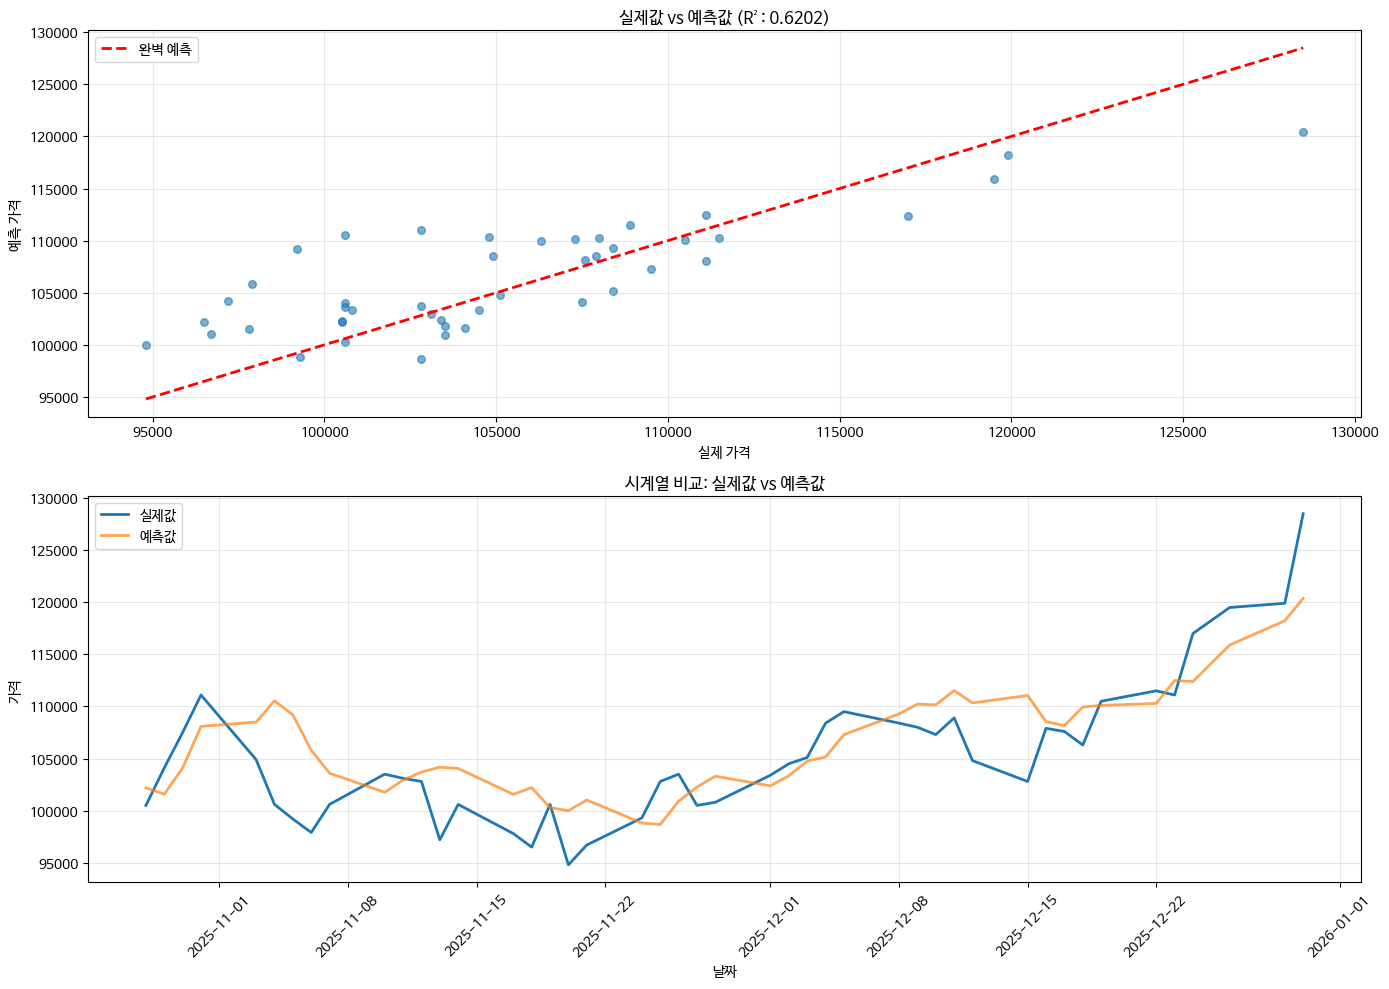

In [26]:
# 예측 결과 시각화
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. 실제값 vs 예측값 산점도 (위)
axes[0].scatter(y_test, y_pred_test, alpha=0.6, s=30)
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', linewidth=2, label='완벽 예측'
)
axes[0].set_xlabel('실제 가격')
axes[0].set_ylabel('예측 가격')
axes[0].set_title(f'실제값 vs 예측값 (R²: {r2_test:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. 시계열 비교 (아래)
test_dates = df.index[split_idx:split_idx + len(y_test)]
axes[1].plot(test_dates, y_test.values, label='실제값', linewidth=2)
axes[1].plot(test_dates, y_pred_test, label='예측값', linewidth=2, alpha=0.7)
axes[1].set_xlabel('날짜')
axes[1].set_ylabel('가격')
axes[1].set_title('시계열 비교: 실제값 vs 예측값')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# 최근 예측 결과 상세
print("[최근 10일 예측 결과]")
print("=" * 60)
recent_results = pd.DataFrame({
    '날짜': df.index[split_idx:split_idx+len(y_test)][-10:],
    '실제종가': y_test.values[-10:],
    '예측종가': y_pred_test[-10:].astype(int),
    '오차': (y_test.values[-10:] - y_pred_test[-10:]).astype(int)
})
display(recent_results)

[최근 10일 예측 결과]


,날짜,실제종가,예측종가,오차
0,2025-12-16,107900.0,108548,-648
1,2025-12-17,107600.0,108161,-561
2,2025-12-18,106300.0,109941,-3641
3,2025-12-19,110500.0,110101,398
4,2025-12-22,111500.0,110292,1207
5,2025-12-23,111100.0,112485,-1385
6,2025-12-24,117000.0,112399,4600
7,2025-12-26,119500.0,115899,3600
8,2025-12-29,119900.0,118225,1674
9,2025-12-30,128500.0,120383,8116


---
## 학습 정리

### 1. 회귀분석 워크플로우
```
데이터 수집 → 특성 생성 → 스케일링 → 모델 학습 → 평가
```

### 2. 핵심 코드
```python
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
```

### 3. 주요 평가 지표
| 지표 | 특징 |
|------|------|
| R2 | 0~1, 높을수록 좋음 |
| RMSE | 원래 단위(원), 낮을수록 좋음 |

### 4. 주의사항
- 주가 예측은 매우 어려운 문제
- R2가 높아도 실제 투자에는 주의
- 과적합(Overfitting) 가능성 항상 고려

---

### 다음 차시 예고
- 21차시: 이진분류로 주가 상승/하락 예측
  - LogisticRegression 사용
  - 분류 평가 지표 (Accuracy, Precision, Recall)